In [1]:
# Clone TimeSformer Repository
!git clone https://github.com/facebookresearch/TimeSformer.git

Cloning into 'TimeSformer'...
remote: Enumerating objects: 392, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 392 (delta 100), reused 74 (delta 74), pack-reused 244 (from 1)
Receiving objects: 100% (392/392), 336.91 KiB | 5.61 MiB/s, done.
Resolving deltas: 100% (176/176), done.


In [2]:
%cd /kaggle/working/TimeSformer

# Install TimeSformer
!pip install -e .

/kaggle/working/TimeSformer
Obtaining file:///kaggle/working/TimeSformer
  Preparing metadata (setup.py) ... done
  Running setup.py develop for timesformer


In [3]:
!pip install simplejson fvcore iopath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.9 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=6ba9c29afe826e016cac3699f84847c30f29d1d1b93fc996692cfc6da0f88172
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=71c6d81ebc7e129b94e10fb3249be580a8e3fb8b63a75d5663016dfa54edf024
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [4]:
# Open the file in write mode and replace the import line
file_path = "/kaggle/working/TimeSformer/timesformer/models/resnet_helper.py"

# Read and modify the file
with open(file_path, "r") as file:
    lines = file.readlines()

# Replace the line that imports _LinearWithBias
modified_lines = []
for line in lines:
    if "from torch.nn.modules.linear import _LinearWithBias" in line:
        modified_lines.append("from torch.nn import Linear as _LinearWithBias\n")
    else:
        modified_lines.append(line)

# Write the modified content back to the file
with open(file_path, "w") as file:
    file.writelines(modified_lines)

print("File updated successfully!")


File updated successfully!


In [5]:
# Path to vit_utils.py file in your TimeSformer folder
file_path = r"/kaggle/working/TimeSformer/timesformer/models/vit_utils.py"

# Read the content of vit_utils.py
with open(file_path, "r") as file:
    lines = file.readlines()

# Modify the import and update the reference
modified_lines = []
imported = False

for line in lines:
    # Replace the import statement if it exists
    if "from torch._six import container_abcs" in line:
        modified_lines.append("from collections.abc import Iterable\n")
        imported = True
    elif "container_abcs.Iterable" in line or "Iterable" in line:
        modified_lines.append(line.replace("container_abcs.Iterable", "Iterable"))
    else:
        modified_lines.append(line)

# Add import if it's not already there
if not imported:
    modified_lines.insert(0, "from collections.abc import Iterable\n")

# Write the modified content back to the file
with open(file_path, "w") as file:
    file.writelines(modified_lines)

print("✅ vit_utils.py fixed successfully!")


✅ vit_utils.py fixed successfully!


In [6]:
import os
import torch
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from timesformer.models.vit import TimeSformer
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix

In [7]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=8, img_size=224):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.img_size = img_size

        self.videos = []
        self.labels = []

        # Collect videos and labels
        for label, subfolder in enumerate(['NonFight', 'Fight']):
            folder = os.path.join(root_dir, subfolder)
            for file in os.listdir(folder):
                if file.endswith(('.mp4', '.avi', '.mkv')):
                    self.videos.append(os.path.join(folder, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = self.labels[idx]

        # Read video frames
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, frame_count // self.num_frames)

        for i in range(0, frame_count, step):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (self.img_size, self.img_size))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

            if len(frames) >= self.num_frames:
                break

        cap.release()

        # Pad if not enough frames
        while len(frames) < self.num_frames:
            frames.append(frames[-1])

        frames = np.stack(frames)  # Shape: (num_frames, H, W, C)
        frames = torch.from_numpy(frames).permute(3, 0, 1, 2).float() / 255.0  # (C, T, H, W)

        if self.transform:
            frames = self.transform(frames)

        return frames, torch.tensor(label, dtype=torch.float32)  # Float labels for BCE

In [8]:
# # Detect TPU
# device = xm.xla_device()
# # Move to GPU if available

try:
    device = xm.xla_device()
except:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [9]:
# Load pre-trained TimeSformer model
model = TimeSformer(img_size=224, num_classes=400)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


In [10]:
# checkpoint = torch.load(r"/kaggle/input/timesformer_pytorch/pytorch/default/1/timesformer_binary_final1.pth", map_location="cuda")
# model.load_state_dict(checkpoint["model_state"], strict=False)

In [11]:
# Modify the final layer for binary classification
model.model.head = nn.Sequential(
    nn.Linear(model.model.head.in_features, 256),  # Intermediate layer
    nn.ReLU(),
    nn.Linear(256, 1)  # Binary output (logit)
)

In [12]:
model = model.to(device)

# Freeze pretrained layers initially
for param in model.parameters():
    param.requires_grad = False
for param in model.model.head.parameters():
    param.requires_grad = True

In [13]:
torch.cuda.is_available()

True

In [14]:
# Parameters
batch_size = 8
learning_rate = 1e-5

In [15]:
# # Load dataset
# train_dataset = VideoDataset(root_dir=r'Y:\TSF\TimeSformer\dataset', num_frames=8, img_size=224)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
# Define dataset paths for RWF-2000
train_dataset = VideoDataset(root_dir=r'/kaggle/input/rwf2000/RWF-2000/train', num_frames=8, img_size=224)
val_dataset = VideoDataset(root_dir=r'/kaggle/input/rwf2000/RWF-2000/val', num_frames=8, img_size=224)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [17]:
pos_weight = torch.tensor([2.0]).to(device)

In [18]:
# Loss function
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)  # Binary cross-entropy loss with logits

In [19]:

# Optimizer with different learning rates
base_params = [param for name, param in model.named_parameters() if "head" not in name]
head_params = model.model.head.parameters()
optimizer = optim.Adam([
    {'params': base_params, 'lr': learning_rate * 0.1},  # Slow lr for pretrained layers
    {'params': head_params, 'lr': learning_rate}         # Faster lr for new head
])

In [20]:
torch.cuda.empty_cache()

In [21]:
epochs = 1
train_losses = []  # 🔹 Store average loss per epoch

for epoch in range(epochs):
    model.train() 
    total_loss = 0.0

    for batch_idx, (videos, labels) in enumerate(train_loader):
        videos, labels = videos.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos).squeeze(1)  # Shape: [batch_size]
        loss = criterion(outputs, labels.float())  # Ensure labels are float for BCE loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # 🔹 Store average loss
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

    # Optional: Unfreeze some layers after epoch 2
    if epoch == 2:
        for param in model.parameters():
            param.requires_grad = True


Epoch [1/1], Batch [0/200], Loss: 0.9870
Epoch [1/1], Batch [10/200], Loss: 1.0017
Epoch [1/1], Batch [20/200], Loss: 0.9605
Epoch [1/1], Batch [30/200], Loss: 1.1409
Epoch [1/1], Batch [40/200], Loss: 0.9954
Epoch [1/1], Batch [50/200], Loss: 1.0093
Epoch [1/1], Batch [60/200], Loss: 0.9249
Epoch [1/1], Batch [70/200], Loss: 0.9335
Epoch [1/1], Batch [80/200], Loss: 0.9480
Epoch [1/1], Batch [90/200], Loss: 0.9063
Epoch [1/1], Batch [100/200], Loss: 0.9715
Epoch [1/1], Batch [110/200], Loss: 0.9153
Epoch [1/1], Batch [120/200], Loss: 0.9132
Epoch [1/1], Batch [130/200], Loss: 0.9555
Epoch [1/1], Batch [140/200], Loss: 0.9392
Epoch [1/1], Batch [150/200], Loss: 0.9361
Epoch [1/1], Batch [160/200], Loss: 0.9243
Epoch [1/1], Batch [170/200], Loss: 0.9503
Epoch [1/1], Batch [180/200], Loss: 0.9508
Epoch [1/1], Batch [190/200], Loss: 0.9842
Epoch [1/1], Average Loss: 0.9523


In [22]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'checkpoint.pth')

# === Loading ===
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1



<ipython-input-22-afc4336fa450>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth')


In [23]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report,
    f1_score, accuracy_score, precision_score, recall_score,
    roc_curve, roc_auc_score
)

def evaluate_model(model, val_loader, train_losses, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # 👉 Confusion Matrix
    conf_mat = confusion_matrix(all_labels, all_preds)
    print("\n🔷 Confusion Matrix:\n", conf_mat)

    # 👉 Classification Report
    print("\n🔷 Classification Report:\n", classification_report(all_labels, all_preds, digits=4))

    # 👉 Accuracy, Precision, Recall, F1
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"✅ Accuracy:  {acc:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall:    {rec:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")

    # 👉 Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
    plt.title("🔹 Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 👉 Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc_score = roc_auc_score(all_labels, all_probs)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("🔹 ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 👉 Plot Loss Graph
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
    plt.title("🔹 Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()




🔷 Confusion Matrix:
 [[  2 198]
 [  0 200]]

🔷 Classification Report:
               precision    recall  f1-score   support

         0.0     1.0000    0.0100    0.0198       200
         1.0     0.5025    1.0000    0.6689       200

    accuracy                         0.5050       400
   macro avg     0.7513    0.5050    0.3443       400
weighted avg     0.7513    0.5050    0.3443       400

✅ Accuracy:  0.5050
✅ Precision: 0.5025
✅ Recall:    1.0000
✅ F1 Score:  0.6689


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


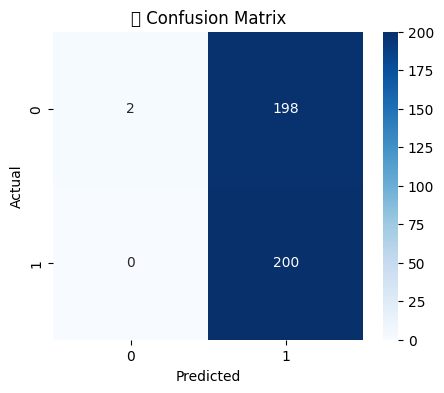

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


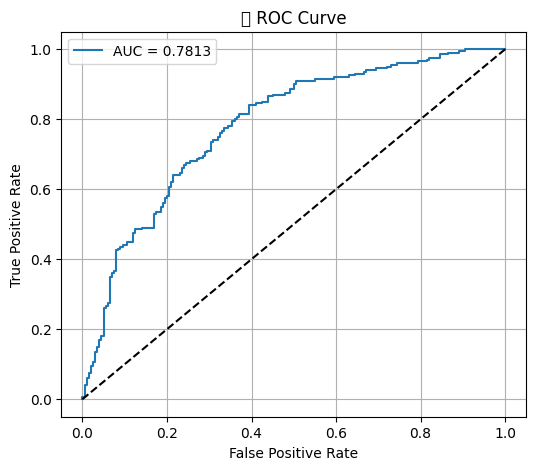

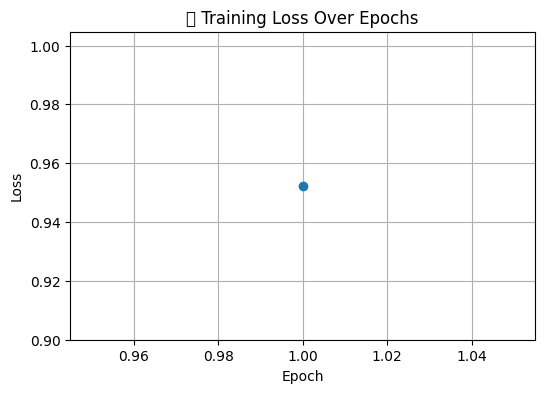

In [24]:
evaluate_model(model, val_loader, train_losses, device)

Accuracy: 0.5050
Confusion Matrix:
[[  2 198]
 [  0 200]]


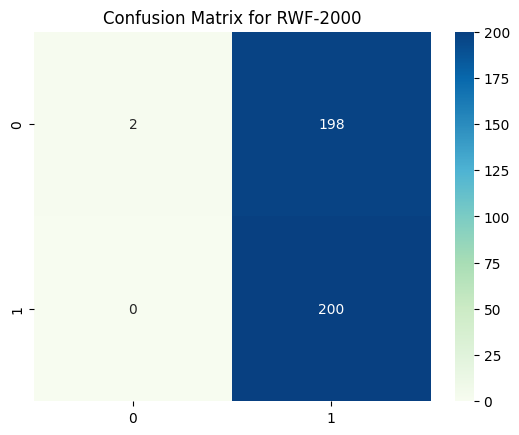

In [25]:
# Evaluation on Validation Data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in val_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos).squeeze(1)
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        preds = (probs > 0.5).float()  # Threshold for binary classification

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy and confusion matrix
acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {acc:.4f}')
print(f'Confusion Matrix:\n{cm}')

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, cmap="GnBu", annot=True, fmt='d')
plt.title("Confusion Matrix for RWF-2000")
plt.show()


In [26]:
%ls -l

total 476152
-rw-r--r-- 1 root root 487499333 Apr 16 08:42 checkpoint.pth
-rwxr-xr-x 1 root root       244 Apr 16 08:35 CODE_OF_CONDUCT.md*
drwxr-xr-x 4 root root      4096 Apr 16 08:35 configs/
-rwxr-xr-x 1 root root       983 Apr 16 08:35 CONTRIBUTING.md*
-rw-r--r-- 1 root root       328 Apr 16 08:35 environment.yml
-rw-r--r-- 1 root root      1764 Apr 16 08:35 example.ipynb
-rwxr-xr-x 1 root root     19332 Apr 16 08:35 LICENSE*
-rwxr-xr-x 1 root root     10930 Apr 16 08:35 README.md*
-rwxr-xr-x 1 root root       748 Apr 16 08:35 setup.cfg*
-rwxr-xr-x 1 root root       570 Apr 16 08:35 setup.py*
drwxr-xr-x 2 root root      4096 Apr 16 08:35 slurm_scripts/
drwxr-xr-x 8 root root      4096 Apr 16 08:35 timesformer/
drwxr-xr-x 2 root root      4096 Apr 16 08:35 timesformer.egg-info/
drwxr-xr-x 2 root root      4096 Apr 16 08:35 tools/


In [27]:
# Save fine-tuned model
torch.save(model.state_dict(), "/kaggle/working/timesformer_binary_final1.pth")

In [28]:
# Load for future inference_
model.load_state_dict(torch.load("/kaggle/input/timesformer_pytorch/pytorch/default/1/timesformer_binary_final1.pth"))

<ipython-input-28-9d65a75b1e7c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/timesformer_pytorch/pytorch/default/1/timesf

<All keys matched successfully>

In [29]:

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos).squeeze(1)
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        preds = (probs > 0.5).float()  # Use threshold for binary classification
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



In [30]:
# Calculate accuracy and confusion matrix
acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {acc:.4f}')
print(f'Confusion Matrix:\n{cm}')

Accuracy: 0.9731
Confusion Matrix:
[[759  41]
 [  2 798]]


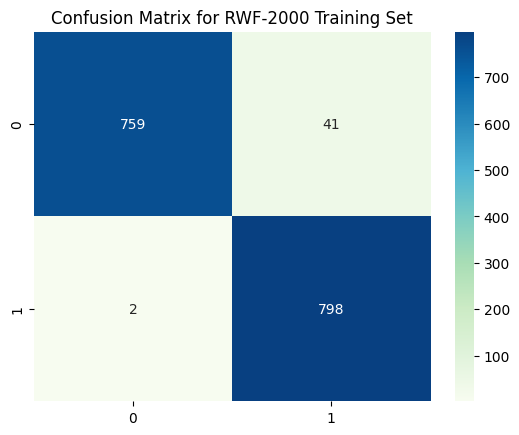

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, cmap="GnBu", annot=True, fmt='d')
plt.title("Confusion Matrix for RWF-2000 Training Set", )

plt.show()

In [32]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

for name, param in model.named_parameters():
    print(f"{name}: {param.shape} | Requires Grad: {param.requires_grad}")


Total Parameters: 121455873
Trainable Parameters: 197121
model.cls_token: torch.Size([1, 1, 768]) | Requires Grad: False
model.pos_embed: torch.Size([1, 197, 768]) | Requires Grad: False
model.time_embed: torch.Size([1, 8, 768]) | Requires Grad: False
model.patch_embed.proj.weight: torch.Size([768, 3, 16, 16]) | Requires Grad: False
model.patch_embed.proj.bias: torch.Size([768]) | Requires Grad: False
model.blocks.0.norm1.weight: torch.Size([768]) | Requires Grad: False
model.blocks.0.norm1.bias: torch.Size([768]) | Requires Grad: False
model.blocks.0.attn.qkv.weight: torch.Size([2304, 768]) | Requires Grad: False
model.blocks.0.attn.qkv.bias: torch.Size([2304]) | Requires Grad: False
model.blocks.0.attn.proj.weight: torch.Size([768, 768]) | Requires Grad: False
model.blocks.0.attn.proj.bias: torch.Size([768]) | Requires Grad: False
model.blocks.0.temporal_norm1.weight: torch.Size([768]) | Requires Grad: False
model.blocks.0.temporal_norm1.bias: torch.Size([768]) | Requires Grad: False

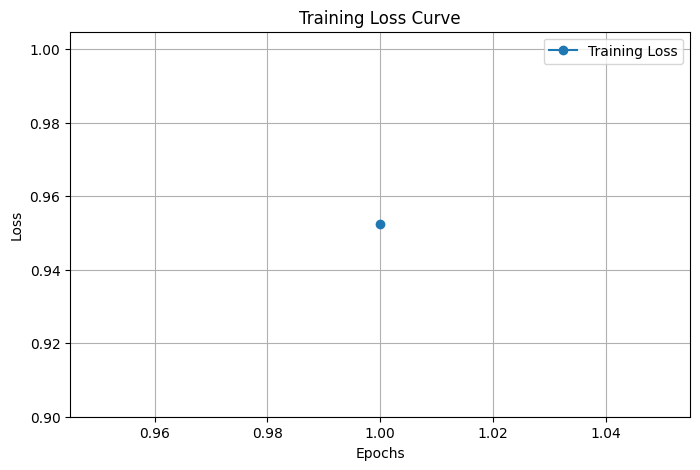

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
import torch
import torch.nn as nn
from timesformer.models.vit import TimeSformer

# Define the correct model with custom head
class ModifiedTimeSformer(TimeSformer):
    def __init__(self, img_size=224, num_classes=1):
        super(ModifiedTimeSformer, self).__init__(img_size=img_size, num_classes=num_classes)
        
        # Correctly restore the custom head you used during training
        self.model.head = nn.Sequential(
            nn.Linear(self.model.head.in_features, 256),  # Intermediate layer
            nn.ReLU(),
            nn.Linear(256, 1)  # Binary classification (logit output)
        )

# Instantiate the modified model
model_path = "/kaggle/input/timesformer_pytorch/pytorch/default/1/timesformer_binary_final1.pth"  # Correct path to your model
model = ModifiedTimeSformer(img_size=224)
model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.to("cuda")
model.eval()

print("✅ Model loaded successfully with custom head!")


<ipython-input-34-ab8511db9441>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cuda"))


✅ Model loaded successfully with custom head!


In [35]:
# Function to preprocess the video
def preprocess_video(video_path, num_frames=8, img_size=224):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // num_frames)

    for i in range(0, frame_count, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (img_size, img_size))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

        if len(frames) >= num_frames:
            break

    cap.release()

    # Pad if not enough frames
    while len(frames) < num_frames:
        frames.append(frames[-1])

    frames = np.stack(frames)  # Shape: (num_frames, H, W, C)
    frames = torch.from_numpy(frames).permute(3, 0, 1, 2).float() / 255.0  # (C, T, H, W)
    frames = frames.unsqueeze(0).to("cuda")  # Add batch dimension: (1, C, T, H, W)

    return frames


In [36]:
# Function to make a prediction
def predict_video(video_path):
    # Preprocess video
    video_tensor = preprocess_video(video_path)

    # Make prediction
    with torch.no_grad():
        outputs = model(video_tensor).squeeze(1)
        print(f"Raw Logit Value: {outputs}") 
        probs = torch.sigmoid(outputs).item()  # Convert logits to probability

    # Define threshold for binary classification
    threshold = 0.3
    prediction = "Fight" if probs < threshold else "NonFight"
    
    print(f"Prediction: {prediction}")
    print(f"Confidence: {probs:.4f}")
    return prediction, probs


In [37]:
# Path to the video for prediction
video_path = "/kaggle/input/rwf2000/RWF-2000/val/NonFight/1MVS2QPWbHc_0.avi"  # Change path accordingly

# Run prediction
predict_video(video_path)


Raw Logit Value: tensor([-1.6996], device='cuda:0')
Prediction: Fight
Confidence: 0.1545


('Fight', 0.1545216292142868)